In [190]:
import torch
import torchvision

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import mplcyberpunk
plt.style.use('cyberpunk')

In [182]:
# check the version of torch and torchvision
print(torch.__version__, torchvision.__version__)

# setup device agnoustic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu128 0.23.0+cu128
cpu


### Loading, Exploring and Preparing the dataset

we are going to use FashionMNIST Dataset from torch vision

In [312]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Inspect the data size, type and shape of the training and testing data

In [315]:
# Inspection of the training data
print(f"Training data features: shape: {training_data.data.shape}, dtype: {training_data.data.dtype}")
print(f"Training data targets: shape: {training_data.targets.shape}, dtype: {training_data.targets.dtype}")

# Inspection of the testing data
# print(f"Testing data features: shape: {X_test.shape}, dtype: {X_test.dtype}")
# print(f"Testing data targets: shape: {y_test.shape}, dtype: {y_test.dtype}")

Training data features: shape: torch.Size([60000, 28, 28]), dtype: torch.uint8
Training data targets: shape: torch.Size([60000]), dtype: torch.int64


We are now going to inspect samples of the data to see the data in random positions

In [317]:
print("Sample training data")
print(training_data.data[0])

print("sample of training targres")
print(training_data.targets[:10])

print("training labels are")
print(training_data.classes)

Sample training data
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,  

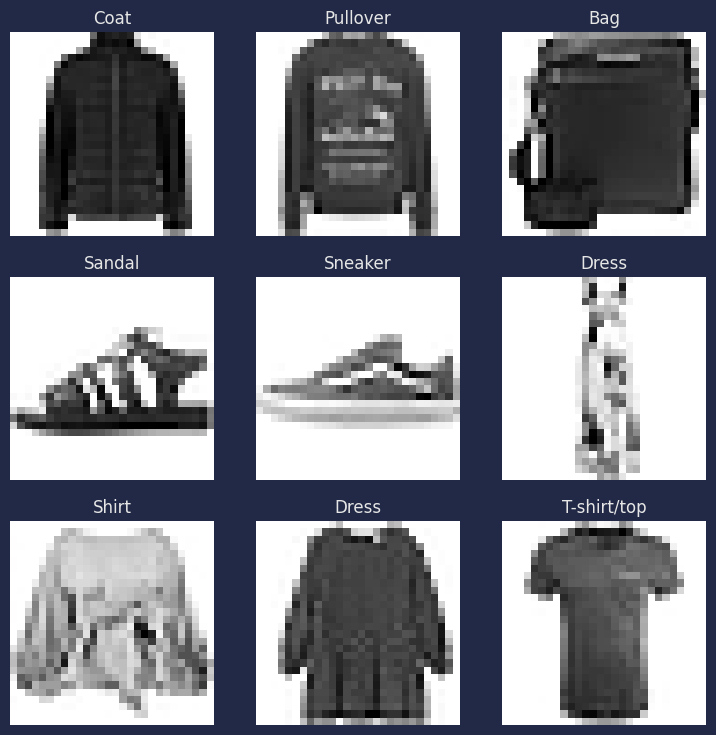

In [326]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(training_data), (1,)).item()
    fig.add_subplot(rows, cols, i)
    image, target = training_data[random_idx]
    plt.imshow(image.squeeze(), cmap=plt.cm.gray_r)
    plt.title(training_data.classes[target])
    plt.axis('off')
plt.show()


Now we are going to use torch Dataloader to helo with creating mini-batches to load this data into a nueral network

In [328]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=testing_data, batch_size=BATCH_SIZE, shuffle=False)